In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.ddpg.td3 as td3

import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
#from simple_pid import PID

import dill
import pickle
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import itertools
%matplotlib inline

import pandas as pd

In [2]:
home_path = '/home/sgillen/work/'

checkpoint_path = home_path + \
"seagul/seagul/notebooks/lorenz/data/tune/custom_reward/PPO/PPO_linear_z-v0_21a281cc_2020-02-12_21-31-48o6kp5nwx/checkpoint_455/checkpoint-455"

In [3]:
# Some delightfully ugly python to infer where everything else is...
config_path =  '/'.join(checkpoint_path.split('/')[:-2]) + '/params.pkl'
config = dill.load(open(config_path, 'rb'))
env_name = config['env']

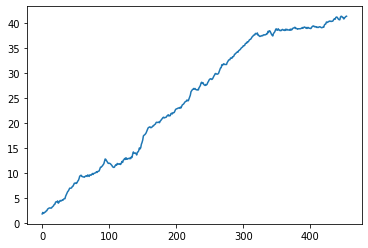

In [4]:
csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
df = pd.read_csv(csv_path)
plt.plot(df['episode_reward_mean'])

In [5]:
ray.shutdown()
ray.init()

trainer = ppo.PPOTrainer(config)#, config['env_name'])
#trainer = td3.TD3Trainer(config)
#trainer = ddpg.DDPGTrainer(config)
#trainer = sac.SACTrainer(config)

trainer.restore(checkpoint_path)

2020-02-13 13:52:10,744	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-13 13:52:10,745	INFO resource_spec.py:212 -- Starting Ray with 11.67 GiB memory available for workers and up to 5.85 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-13 13:52:11,064	INFO services.py:1093 -- View the Ray dashboard at localhost:8265
2020-02-13 13:52:11,339	INFO trainer.py:370 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-02-13 13:52:11,352	INFO trainer.py:517 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-02-13 13:52:15,702	WARNING trainable.py:210 -- Getting current IP.
2020-02-13 13:52:15,703	INFO trainable.py:416 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/seagul/seagul/notebooks/lorenz/data/tune/custom_reward/PPO/PPO_li

# Rollouts

In [22]:
def do_rollout(init_point):
    env = gym.make(env_name, **config['env_config'])
    obs = env.reset(init_point)

    action_hist = []
    m_act_hist = []
    obs_hist = []
    reward_hist = []

    done = False

    while not done:
        actions, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
        obs, reward, done, _ = env.step(np.asarray(actions))

        action_hist.append(np.copy(actions))
        obs_hist.append(np.copy(obs))
        reward_hist.append(np.copy(reward))


    action_hist = np.stack(action_hist)
    obs_hist = np.stack(obs_hist)
    reward_hist = np.stack(reward_hist)
    
    return obs_hist, action_hist, reward_hist


obs_hist, action_hist, reward_hist = do_rollout(init_point = np.random.uniform(-10,10,3))
print(sum(reward_hist))


#plt.plot(action_hist)
#plt.figure()
#plt.figure()
#plt.plot(obs_hist)
#plt.figure()

2000.0


Text(0.5, 1.0, 'Actions')

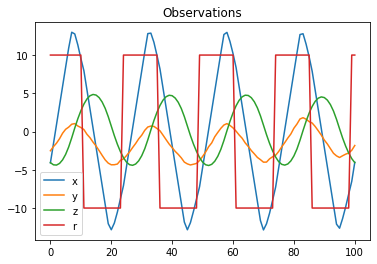

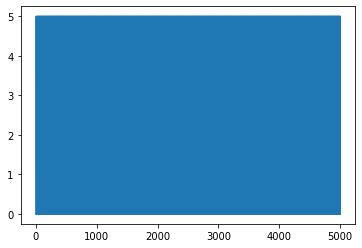

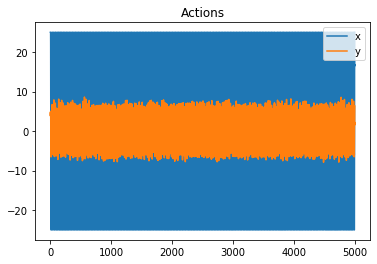

In [26]:
plt.plot(obs_hist[4900:,:])
plt.title('Observations')
plt.legend(['x', 'y', 'z', 'r'])

plt.figure()
plt.plot(reward_hist)

plt.figure()
plt.plot(action_hist)
plt.legend(['x', 'y'])
plt.title('Actions')

In [ ]:
obs_arr = np.stack(obs_hist)

x = obs_arr[:,0]; y = obs_arr[:,1]; z = obs_arr[:,2]

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram')

# Local Point Analysis

In [55]:
num_steps = config['env_config']['num_steps']
config['env_config']['num_steps'] = 5000
obs_hist, _ , _ = do_rollout(np.array([0,0,0]))
limit_set = obs_hist[4900:,:]

config['env_config']['num_steps'] = num_steps
seed_point = np.array([0,0,0])
dx = dy = dz = 1e-8

deltas = itertools.product([-dx, dx, 0], [-dy, dy, 0], [-dz, dz, 0])
deltas = np.array(list(deltas))

init_points = seed_point + deltas

final_points = np.zeros_like(init_points)
min_points = np.zeros_like(init_points)
trajs = np.zeros((init_points.shape[0], config['env_config']['num_steps']+1, init_points.shape[1]))

trainer.get_policy().cur_noise_scale = 0.0

for i, init_point in enumerate(init_points):
    obs_hist, act_hist, rew_hist = do_rollout(init_point)
    trajs[i,:] = obs_hist[:,:3]
    final_points[i,:] = obs_hist[-1,:3]
    min_obs = np.min(obs_hist[:,:3] - init_point,axis=1)
    max_obs = np.max(obs_hist[:,:3] - init_point,axis=1)

In [55]:
min_x = np.zeros(num_steps)
min_y = np.zeros(num_steps)
min_z = np.zeros(num_steps)
min_d = np.zeros(num_steps)


for i in range(trajs.shape[0]):
    for t in range(num_steps):
        min_x[t] = np.min(np.linalg.norm(trajs[i,t,0] - limit_set[:,0]))
        min_y[t] = np.min(np.linalg.norm(trajs[i,t,1] - limit_set[:,1]))
        min_z[t] = np.min(np.linalg.norm(trajs[i,t,2] - limit_set[:,2]))

        min_d[t] = np.min(np.linalg.norm(trajs[i,t,:] - limit_set)) 

In [ ]:
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,0])
    plt.title("X trajectories, d* = " + str(dx))
    
plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,1])
    plt.title("Y trajectories, d* = " + str(dy))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,2])
    plt.title("Z trajectories, d* = " + str(dz))

In [ ]:
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(np.sum(np.sqrt((trajs[i,:,:] - trajs[-1,:,:])**2), axis=1))
    plt.title("Euclidean distance from nominal, d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(np.sum(np.sqrt((trajs[i,:,0::2] - trajs[-1,:,0::2])**2), axis=1))
    plt.title("Euclidean distance excluding Y from nominal, d* = " + str(dx))
    
plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(np.sum(trajs[i,:,:] - trajs[-1,:,:], axis=1))
    plt.title("Total difference from nominal, d* = " + str(dx))
    
plt.figure()    
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,0] - trajs[-1,:,0])
    plt.title("X distance from nominal , d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,1] - trajs[-1,:,1])
    plt.title("Y distance from nominal , d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,2] - trajs[-1,:,2])
    plt.title("Z distance from nominal, d* = " + str(dx))
   

for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,2] - trajs[-1,:,2])
    plt.title("Z distance from nominal, d* = " + str(dx))

# Global point analysis

In [ ]:
num_points = int(1e3)
config["env_config"]["num_steps"] = 1000

init_points = np.random.uniform(low = np.array([-10,-10,-10]), high = np.array([10, 10, 10]), size=(num_points,3))
final_points = np.zeros_like(init_points)
trajs = np.zeros((init_points.shape[0], config["env_config"]["num_steps"]+1, init_points.shape[1]))

for i, init_point in enumerate(init_points):
    obs_hist, act_hist, rew_hist = do_rollout(init_point)
    trajs[i,:] = obs_hist[:,:3]
    final_points[i,:] = obs_hist[-1,:3]

In [ ]:
plt.scatter(init_points[:,0], init_points[:,2])
plt.scatter(final_points[:,0], final_points[:,2])
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.legend(['initial', 'final'])

# Network output analysis

In [ ]:
num_points = 1000

obs = np.array([0.0,0.0,0.0,10.0])

ys  = np.linspace(-10,10,num_points)
xs  = np.linspace(0,10,num_points)

action_arr = np.zeros((num_points, 2))
var = np.zeros((num_points,2))
logp = np.zeros((num_points,1))
vf_preds = np.zeros((num_points,1))

for i,xy in enumerate(zip(xs,ys)):
    x = xy[0]; y = xy[1]
    
    obs[0] = x; #obs[1] = y
    
    sampled_action, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
    actions = out_dict['behaviour_logits'][0:2]
    var[i] = out_dict['behaviour_logits'][2:]
    logp[i] = out_dict['action_logp']
    vf_preds[i] = out_dict['vf_preds']


    action_arr[i] = actions
    
    
plt.plot(xs, action_arr[:,0], 'x')
plt.plot(xs, action_arr[:,1], 'x')